In [1]:
from matplotlib import pyplot as plt
import numpy as np

In [2]:
from lstm_policy import pad_and_concat
from dpll import DPLL, RandomClauseDPLL, MostCommonVarDPLL, RandomVarDPLL
from cnf import get_random_kcnf, CNF

In [3]:
import tensorflow as tf

BATCH_SIZE = 64

sess=tf.Session()    
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph('models/activepolicy-18-03-20-103135/model-40000000.meta')
sess.run(tf.global_variables_initializer())
saver.restore(sess, tf.train.latest_checkpoint('./models/activepolicy-18-03-20-103135/.'))

# Now, let's access and create placeholders variables and
# create feed-dict to feed new data

graph = tf.get_default_graph()

INFO:tensorflow:Restoring parameters from ./models/activepolicy-18-03-20-103135/./model-40000000


In [4]:
g_inputs = graph.get_tensor_by_name("inputs:0")
g_lengths = graph.get_tensor_by_name("lengths:0")

In [5]:
g_policy_probs = graph.get_tensor_by_name('policy_prob:0')
g_sat_probs = graph.get_tensor_by_name('sat_prob:0')

In [6]:
np.set_printoptions(precision=3, suppress=True)

In [7]:
inputs = np.asarray([[[1, 1, 3], [1, -3, 2], [1, 3, 4], [-2, -3, 4]]] * BATCH_SIZE, dtype=np.int32)
lengths = np.asarray([inputs.shape[1]] * 64, dtype=np.int32)

sat_prob, policy_probs = sess.run([g_sat_probs, g_policy_probs], feed_dict={g_inputs: inputs, g_lengths: lengths})

print(sat_prob[0], policy_probs[0])

1.0 [1.    0.308 1.    1.    1.    1.    1.    1.   ]


In [8]:
# Because we have to pass full batch

logfile = open("/tmp/log", "w")

class LSTMBasedDPLL(DPLL):
    def suggest(self, input_cnf: CNF):
        cnfs = [input_cnf] * BATCH_SIZE
        cnfs_clauses = [[claus + tuple([claus[0]] * (3-len(claus))) for claus in cnf.clauses] for cnf in cnfs]
        inputs, lengths = pad_and_concat(cnfs_clauses)
        
        policy_probs = sess.run(g_policy_probs, feed_dict={g_inputs: inputs, g_lengths: lengths})
        
        print("CNF:", input_cnf, end=' ', file=logfile)
        print('cnf_clauses[0]', cnfs_clauses[0], end=' ', file=logfile)
        print("probs:",  policy_probs[0], end=' \n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][(var-1)*2 + (0 if svar > 0 else 1)]
                print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        print("svar:", svar, file=logfile)
        return best_svar

In [9]:
def compute_steps(sats, dpll_cls):
    steps = []
    for sat in sats:
        dpll = dpll_cls()
        res = dpll.run(sat)
        assert res is not None
        steps.append(dpll.number_of_runs)
    return steps

In [10]:
def compute_and_print_steps(sats, dpll_cls):
    steps = compute_steps(sats, dpll_cls)
    print("#Sats: {}; avg step: {}; stdev step: {}".format(
        len(steps), np.mean(steps), np.std(steps)))
    plt.title("Steps of {}".format(dpll_cls.__name__))
    plt.hist(steps, bins=range(2**(N+1)))
    plt.show()

In [11]:
def print_all(s, k, n, m):
    global S, K, N, M
    S = s
    K = k
    N = n
    M = m
    
    MAX_TRIES = 10000
    sats = []
    for index in range(MAX_TRIES):
        if len(sats) >= S:
            break
        sat = get_random_kcnf(K, N, M)
        if DPLL().run(sat) is not None:
            sats.append(sat)
    assert len(sats) == S
    compute_and_print_steps(sats, DPLL)
    compute_and_print_steps(sats, RandomVarDPLL)
    compute_and_print_steps(sats, RandomClauseDPLL)
    compute_and_print_steps(sats, LSTMBasedDPLL)
    compute_and_print_steps(sats, MostCommonVarDPLL)

#Sats: 400; avg step: 3.665; stdev step: 1.1281733022900338


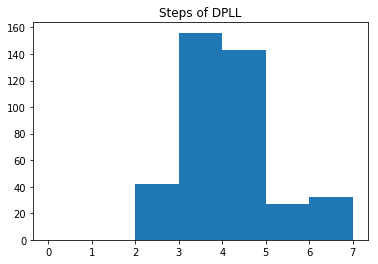

#Sats: 400; avg step: 3.69; stdev step: 1.137497252743935


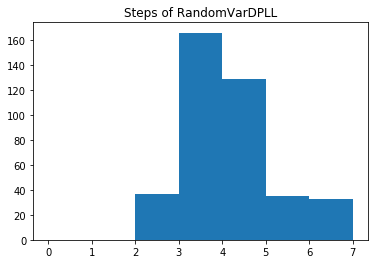

#Sats: 400; avg step: 2.9875; stdev step: 0.7761080788137693


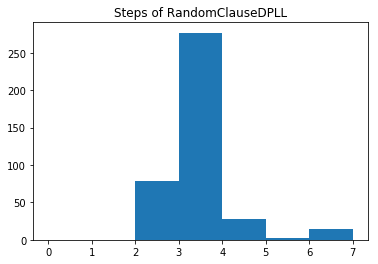

#Sats: 400; avg step: 2.84; stdev step: 0.3666060555964672


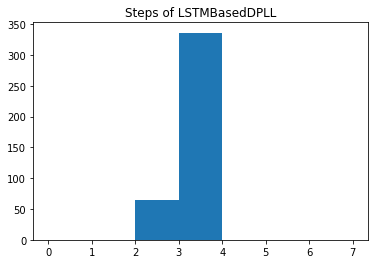

#Sats: 400; avg step: 2.635; stdev step: 0.48659531440407444


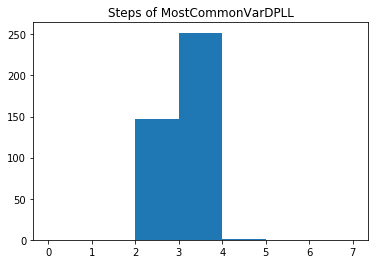

In [12]:
print_all(400, 2, 2, 3)

#Sats: 400; avg step: 4.3525; stdev step: 1.5582823075425067


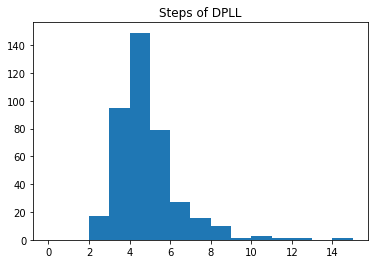

#Sats: 400; avg step: 4.33; stdev step: 1.507016920940173


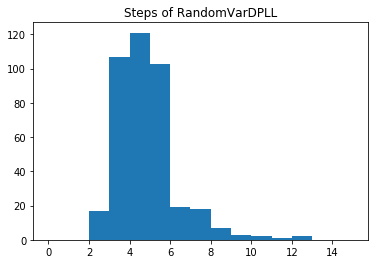

#Sats: 400; avg step: 3.2625; stdev step: 0.7801241888314963


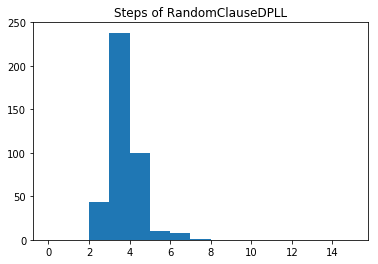

#Sats: 400; avg step: 3.3; stdev step: 0.5744562646538028


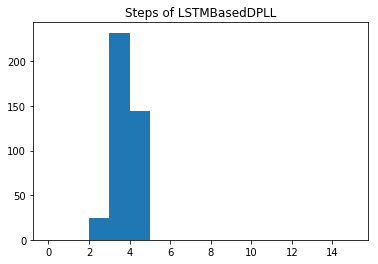

#Sats: 400; avg step: 2.9125; stdev step: 0.5337075510052299


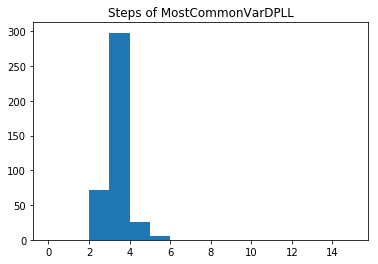

In [13]:
print_all(400, 2, 3, 3)

#Sats: 400; avg step: 4.8375; stdev step: 1.783562095919287


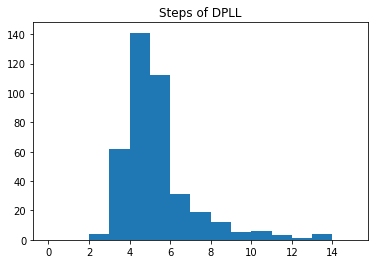

#Sats: 400; avg step: 5.0275; stdev step: 1.869958221458437


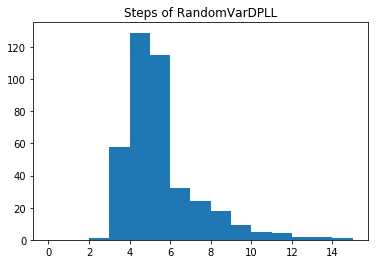

#Sats: 400; avg step: 4.0175; stdev step: 1.3936261155704568


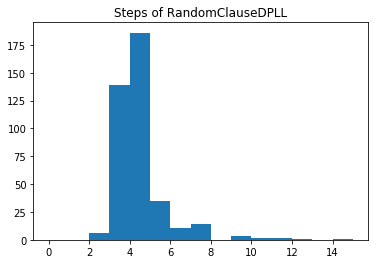

#Sats: 400; avg step: 3.7025; stdev step: 0.4837290047123493


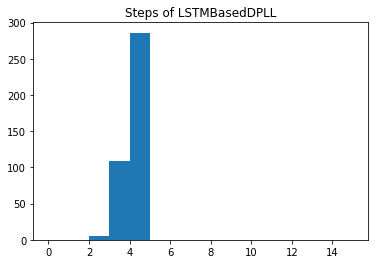

#Sats: 400; avg step: 3.3925; stdev step: 0.9292167400558387


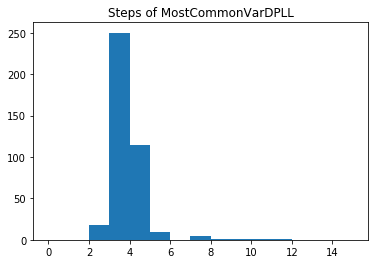

In [14]:
print_all(400, 3, 3, 6)

#Sats: 100; avg step: 10.42; stdev step: 5.113081262800348


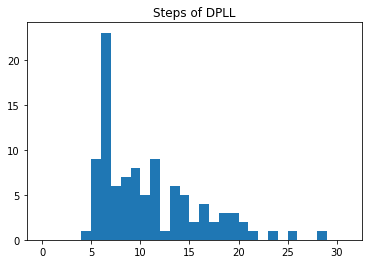

#Sats: 100; avg step: 10.28; stdev step: 5.026091921164992


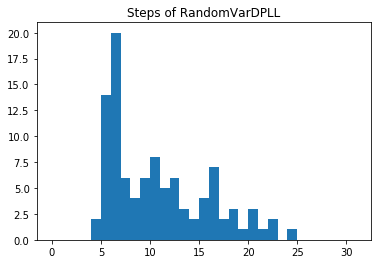

#Sats: 100; avg step: 7.97; stdev step: 3.7052800164090165


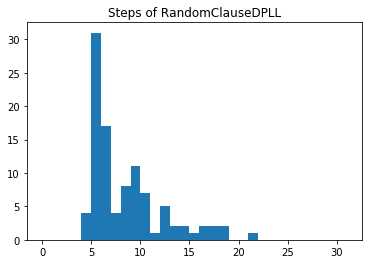

#Sats: 100; avg step: 4.97; stdev step: 0.1705872210923198


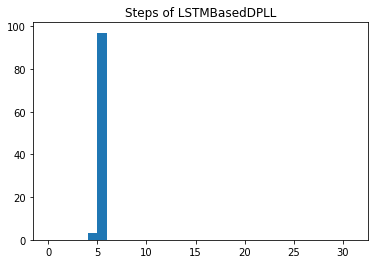

#Sats: 100; avg step: 6.31; stdev step: 2.931535433863967


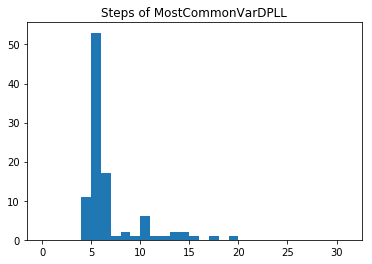

In [15]:
print_all(100, 3, 4, 20)

#Sats: 100; avg step: 9.77; stdev step: 4.061662221307921


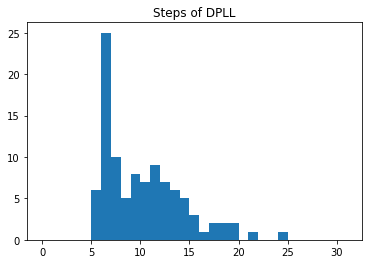

#Sats: 100; avg step: 10.26; stdev step: 3.5485771796594756


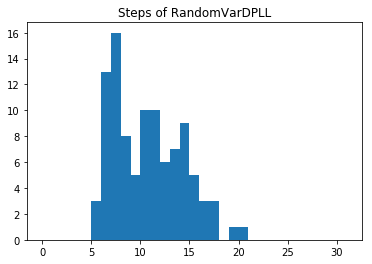

#Sats: 100; avg step: 8.48; stdev step: 3.229489123685045


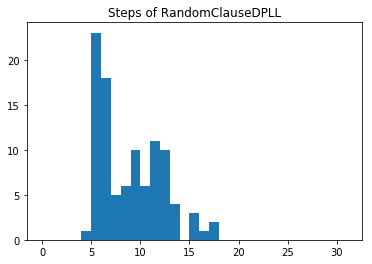

#Sats: 100; avg step: 4.99; stdev step: 0.09949874371066199


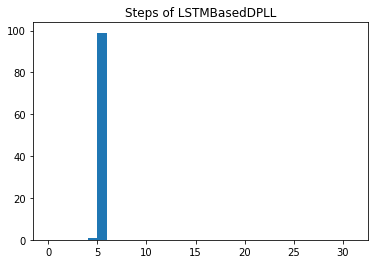

#Sats: 100; avg step: 5.5; stdev step: 1.493318452306808


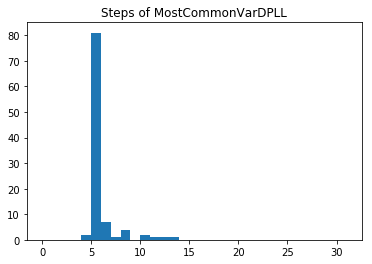

In [16]:
print_all(100, 3, 4, 40)

In [17]:
logfile.close()